In [1]:
# Imports
import sys
sys.path.append("Program")

import datetime as dt
from fundamentals import *
from helper_functions import get_current_date, generate_end_dates, merge_stocks, stock_market
import pandas as pd
pd.options.mode.chained_assignment = None
from plot import *
from scipy.stats import linregress
from stock_screener import create_rs_volume_df, stoploss_target
from technicals import *

In [2]:
# Start of the program
start = dt.datetime.now()

# Initial setup
current_date = get_current_date(start)
current_date = "2024-11-02"

# Variables
NASDAQ_all = False
period_hk = 60 # Period for HK stocks
period_us = 252 # Period for US stocks
RS = 90
factors = [1, 1, 1]
backtest = False

# Index
index_name = "^HSI"
index_dict = {"^HSI": "HKEX", "^GSPC": "S&P 500", "^IXIC": "NASDAQ Composite"}

In [3]:
# Get the stock list of HSI
hkex_df = pd.read_csv("Program/constituents-hsi.csv")
stocks = hkex_df["Symbol"].tolist()

# Get the infix
infix = get_infix(index_name, index_dict, NASDAQ_all)

# Define the result folder
result_folder = "Result"

# Get the price data of the index
index_df = get_df(index_name, current_date)

In [4]:
# Combine the long term and short term RS dataframes
def long_short_RS(current_date, end_date1, end_date2, period1, period2, volume_filter=None):
    # Filter the data
    index_df1 = index_df[index_df.index <= end_date1]
    index_df2 = index_df[index_df.index <= end_date2]

    # Calculate the percent change of the index
    index_df1.loc[:, "Percent Change"] = index_df1["Close"].pct_change()
    index_df2.loc[:, "Percent Change"] = index_df2["Close"].pct_change()
    
    # Calculate the total return of the index
    index_return1 = (index_df1["Percent Change"] + 1).tail(period1).cumprod().iloc[-1]
    index_return2 = (index_df2["Percent Change"] + 1).tail(period2).cumprod().iloc[-1]
    index_shortName = index_dict[f"{index_name}"]
    print(f"Return for {index_shortName} between {index_df1.index[-period1].strftime('%Y-%m-%d')} and {end_date1}: {index_return1:.2f}")
    print(f"Return for {index_shortName} between {index_df2.index[-period2].strftime('%Y-%m-%d')} and {end_date2}: {index_return2:.2f}")

    rs_dfs, volume_dfs, _ = create_rs_volume_df(stocks, current_date, [end_date1, end_date2], [period1, period2], [index_return1, index_return2], index_shortName, result_folder, infix, True, print_multiple=False)
    rs_df1, rs_df2 = rs_dfs
    volume_df1, volume_df2 = volume_dfs

    if volume_filter is not None:
        volume_df1 = volume_df1[(volume_df1["Volume SMA 5 Rank"] <= volume_filter) | (volume_df1["Volume SMA 20 Rank"] <= volume_filter)]
        volume_df2 = volume_df2[(volume_df2["Volume SMA 5 Rank"] <= volume_filter) | (volume_df2["Volume SMA 20 Rank"] <= volume_filter)]

        # Filter rs_df1 and rs_df2 based on the tickers present in volume dataframes
        rs_df1 = rs_df1[rs_df1["Ticker"].isin(set(volume_df1["Ticker"]))]
        rs_df2 = rs_df2[rs_df2["Ticker"].isin(set(volume_df2["Ticker"]))]

    # Merge the two dataframes on "Ticker"
    merged_df = pd.merge(rs_df1, rs_df2, on="Ticker", suffixes=(" 1", " 2"))

    # Rename the columns
    merged_df = merged_df.rename(columns={"RS 1": "Long-term RS", "RS 2": "Short-term RS"})

    # Drop NaN values
    merged_df = merged_df.dropna()

    return merged_df

In [5]:
# Variables
end_date1 = "2024-09-12"
end_date2 = "2024-10-07"
period1 = 252
period2 = 20

# Get the merged dataframe
merged_df = long_short_RS(current_date, end_date1, end_date2, period1, period2)

Return for HKEX between 2023-09-05 and 2024-09-12: 0.91
Return for HKEX between 2024-09-05 and 2024-10-07: 1.32


Processing data for 2024-10-07: 100%|██████████| 82/82 [00:00<00:00, 754.93it/s]


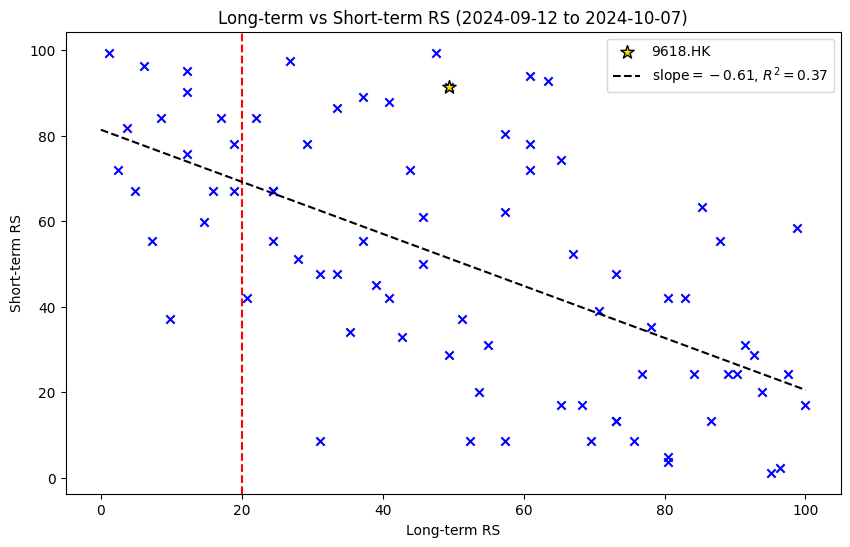

In [6]:
stock_star = "9618.HK"

# Scatter plot of short-term RS against long-term RS
plt.figure(figsize=(10, 6))
plt.scatter(merged_df["Long-term RS"], merged_df["Short-term RS"], color="blue", marker="x")

# Highlight the specific ticker with a star
star = merged_df[merged_df["Ticker"] == stock_star]
if not star.empty:
    plt.scatter(star["Long-term RS"], star["Short-term RS"], color="gold", edgecolor="black", marker="*", s=100, label=stock_star)

# Plot a red vertical line at long-term RS = 20
plt.axvline(x=20, color="red", linestyle="--")

# Calculate the slope and R^2
slope, intercept, r_value, p_value, std_err = linregress(merged_df["Long-term RS"], merged_df["Short-term RS"])
r_squared = r_value**2

# Create the regression line
x_values = np.linspace(0, 100, 100)
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color="black", linestyle="--", label=fr"slope$={slope:.2f}$, $R^2={r_squared:.2f}$")

# Set the axes labels
plt.xlabel("Long-term RS")
plt.ylabel("Short-term RS")

# Set the title
plt.title(f"Long-term vs Short-term RS ({end_date1} to {end_date2})")

# Set the legend
plt.legend()

# Show the plot
plt.show()

In [7]:
# Define the end dates
end_dates = generate_end_dates(1, current_date)

In [8]:
# Initialize two empty lists to store the RS slopes and R^2 values
rs_slopes = []
r_squareds = []

# Iterate over all end dates
for i in tqdm(range(len(end_dates) - 1)):
    start_date = end_dates[i]
    end_date = end_dates[i + 1]

    # Get the merged dataframe
    merged_df = long_short_RS(current_date, start_date, end_date, 252, 20)

    # Calculate the slope and R^2
    rs_slope, _, r_value, _, _ = linregress(merged_df["Long-term RS"], merged_df["Short-term RS"])
    r_squared = r_value**2
    rs_slopes.append(rs_slope)
    r_squareds.append(r_squared)

    # # Scatter plot of short-term RS against long-term RS
    # plt.figure(figsize=(10, 6))
    # plt.scatter(merged_df["Long-term RS"], merged_df["Short-term RS"], color="blue", marker="x")

    # # Highlight the specific ticker with a star
    # star = merged_df[merged_df["Ticker"] == "9618.HK"]
    # if not star.empty:
    #     plt.scatter(star["Long-term RS"], star["Short-term RS"], color="gold", edgecolor="black", marker="*", s=100, label="9618.HK")

    # # Plot a red vertical line at long-term RS = 20
    # plt.axvline(x=20, color="red", linestyle="--")
    
    # # Create the regression line
    # x_values = np.linspace(0, 100, 100)
    # y_values = slope * x_values + intercept
    # plt.plot(x_values, y_values, color="black", linestyle="--", label=fr"slope$={slope:.2f}$, $R^2={r_squared:.2f}$")

    # # Set the axes labels
    # plt.xlabel("Long-term RS")
    # plt.ylabel("Short-term RS")

    # # Set the title
    # plt.title(f"Long-term vs short-term RS ({start_date} to {end_date})")

    # # Set the legend
    # plt.legend()

    # # Show the plot
    # plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

Return for HKEX between 2022-10-21 and 2023-11-01: 1.05
Return for HKEX between 2023-11-06 and 2023-12-01: 0.95


  8%|▊         | 1/12 [00:01<00:17,  1.55s/it]

Return for HKEX between 2022-11-22 and 2023-12-01: 0.95
Return for HKEX between 2023-12-01 and 2024-01-02: 0.99


 17%|█▋        | 2/12 [00:02<00:14,  1.48s/it]

Return for HKEX between 2022-12-19 and 2024-01-02: 0.86
Return for HKEX between 2024-01-05 and 2024-02-01: 0.94


 25%|██▌       | 3/12 [00:04<00:12,  1.43s/it]

Return for HKEX between 2023-01-26 and 2024-02-01: 0.71
Return for HKEX between 2024-02-01 and 2024-03-01: 1.07


 33%|███▎      | 4/12 [00:05<00:11,  1.42s/it]

Return for HKEX between 2023-02-22 and 2024-03-01: 0.81
Return for HKEX between 2024-03-01 and 2024-04-01: 1.00


 42%|████▏     | 5/12 [00:07<00:09,  1.43s/it]

Return for HKEX between 2023-03-21 and 2024-04-01: 0.87
Return for HKEX between 2024-04-02 and 2024-05-01: 1.07


 50%|█████     | 6/12 [00:08<00:08,  1.41s/it]

Return for HKEX between 2023-04-21 and 2024-05-01: 0.87
Return for HKEX between 2024-05-06 and 2024-06-03: 1.00


 58%|█████▊    | 7/12 [00:09<00:07,  1.42s/it]

Return for HKEX between 2023-05-24 and 2024-06-03: 0.95
Return for HKEX between 2024-05-31 and 2024-07-01: 0.97


 67%|██████▋   | 8/12 [00:11<00:05,  1.43s/it]

Return for HKEX between 2023-06-20 and 2024-07-01: 0.89
Return for HKEX between 2024-07-05 and 2024-08-01: 0.96


 75%|███████▌  | 9/12 [00:12<00:04,  1.42s/it]

Return for HKEX between 2023-07-25 and 2024-08-01: 0.93
Return for HKEX between 2024-08-07 and 2024-09-03: 1.06


 83%|████████▎ | 10/12 [00:14<00:02,  1.42s/it]

Return for HKEX between 2023-08-25 and 2024-09-03: 0.97
Return for HKEX between 2024-08-30 and 2024-10-01: 1.19


 92%|█████████▏| 11/12 [00:15<00:01,  1.42s/it]

Return for HKEX between 2023-09-21 and 2024-10-01: 1.18
Return for HKEX between 2024-10-04 and 2024-11-01: 0.93


100%|██████████| 12/12 [00:17<00:00,  1.42s/it]


In [9]:
# Filter the dataframe
index_df = index_df.loc[(index_df.index >= end_dates[0]) & (index_df.index <= end_dates[-1])]

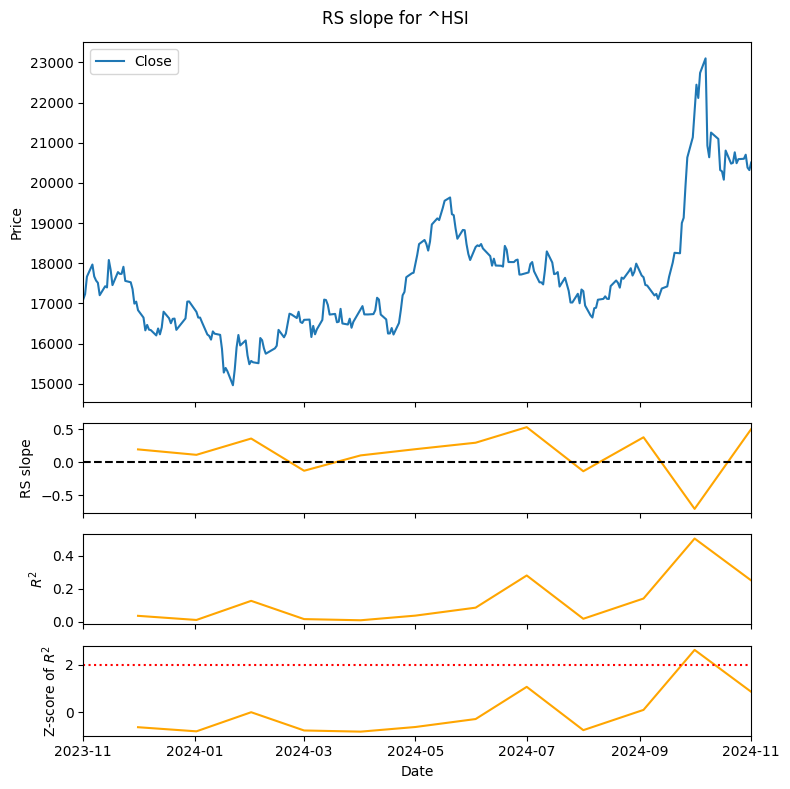

In [10]:
# Create a figure with three subplots, one for the closing price, one for the RS slope, one for the R^2 values, and one for the z-scores of R^2 values
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 8), gridspec_kw={"height_ratios": [4, 1, 1, 1]}, sharex=True)

# Plot the closing price on the first subplot
ax1.plot(index_df["Close"], label="Close")

# Set the y label of the first subplot
ax1.set_ylabel("Price")

# Set the x limit of the first subplot
ax1.set_xlim(index_df.index[0], index_df.index[-1])

# Create a dataframe for RS slope
rs_slope_df = pd.DataFrame({"RS Slope": rs_slopes}, index=pd.to_datetime(end_dates[1:]))

# Plot the RS slope on the second subplot
ax2.plot(rs_slope_df["RS Slope"], color="orange")

# Add a horizontal line at y=0
ax2.axhline(y=0, color="black", linestyle="--")

# Set the y label for the second subplot
ax2.set_ylabel("RS slope")

# Create a dataframe for R^2 values
r_squareds_df = pd.DataFrame({"R^2": r_squareds}, index=pd.to_datetime(end_dates[1:]))

# Plot the R^2 values on the third subplot
ax3.plot(r_squareds_df["R^2"], color="orange")

# Set the y label for the third subplot
ax3.set_ylabel(r"$R^2$")

# Calculate z-scores for R^2 values
r_squared_mean = np.mean(r_squareds_df["R^2"])
r_squared_std = np.std(r_squareds_df["R^2"])
z_scores = (r_squareds_df["R^2"] - r_squared_mean) / r_squared_std

# Plot the z-scores on the fourth subplot
ax4.plot(z_scores, color="orange")

# Add a red dotted line at y=2
ax4.axhline(y=2, color="red", linestyle="dotted")

ax4.set_ylabel(r"Z-score of $R^2$")

# Set the x label
plt.xlabel("Date")

# Set the title
plt.suptitle(f"RS slope for {index_name}")

# Set the legend
ax1.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig(f"Result/Figure/RSslope{index_name}.png", dpi=300)

# Show the plot
plt.show()

In [ ]:
# Choose the stocks
stocks = ["1810.HK", "2618.HK", "3690.HK", "AEM", "CORZ", "DUOL", "POWL"]
for stock in stocks:
    df = get_df(stock, current_date)
    plot_close(stock, df)
    plot_volatility(stock, df, 252)
    plot_MFI_RSI(stock, df, 252)
    if stock.endswith(".HK"):
        plot_stocks(["^HSI", stock], current_date)
    else:
        plot_stocks(["^GSPC", stock], current_date)

In [ ]:
# Get the stop loss and target price of a stock
stock = "CORZ"
df = get_df(stock, current_date)
current_close = df["Close"].iloc[-1]
stoploss, stoploss_pct, target, target_pct = stoploss_target(stock, 12.5, "2024-10-07")
print(f"Plan for {stock}.")
print(f"Current close: {round(current_close, 2)}.")
print(f"SL {stoploss} ({stoploss_pct}%) TP {target} ({target_pct}%)")

In [ ]:
# Calculate the new stop loss
price_avg = 12.9
stoploss_2r = price_avg * (1 - stoploss_pct / 100)
stoploss_2r = round(stoploss_2r, 2)
stoploss_1r = price_avg * (1 - stoploss_pct / 100 / 2)
stoploss_1r = round(stoploss_1r, 2)
stoploss_0r = price_avg
stoploss_0r = round(stoploss_0r, 2)
print(f"SL {stoploss_2r} ({stoploss_pct}%)")
print(f"SL {stoploss_1r} ({stoploss_pct / 2}%)")
print(f"SL {stoploss_0r} (0.0%)")

In [ ]:
show = 252 * 3
stocks = ["GC=F", "SI=F", "HG=F"]
metal_df = merge_stocks(stocks, current_date)
metal_df["Gold/Silver Ratio"] = metal_df["Close (GC=F)"] / metal_df["Close (SI=F)"]
metal_df["Gold/Copper Ratio"] = metal_df["Close (GC=F)"] / metal_df["Close (HG=F)"]
metal_df = calculate_ZScore(metal_df, ["Gold/Silver Ratio", "Gold/Copper Ratio"], 252)

# Restrict the dataframe
metal_df = metal_df[- show:]

# Create a figure with three subplots, one for the metal prices, one for the ratios, one for the ratios z-score
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8), gridspec_kw={"height_ratios": [3, 1, 1]}, sharex=True)

# Plot the metal prices on the first subplot
close_goldfirst = metal_df["Close (GC=F)"].iloc[0]
close_silverfirst = metal_df["Close (SI=F)"].iloc[0]
close_copperfirst = metal_df["Close (HG=F)"].iloc[0]
ax1.plot(100 / close_goldfirst * metal_df["Close (GC=F)"], label="Gold (scaled)", color="gold")
ax1.plot(100 / close_silverfirst * metal_df["Close (SI=F)"], label="Silver (scaled)", color="silver")
ax1.plot(100 / close_copperfirst * metal_df["Close (HG=F)"], label="Copper (scaled)", color="peru")

# Set the label of the first subplot
ax1.set_ylabel("Price")

# Set the x limit of the first subplot
ax1.set_xlim(metal_df.index[0], metal_df.index[-1])

# Plot the ratios on the second subplot
goldsilver_ratio_first = metal_df["Gold/Silver Ratio"].iloc[0]
goldcopper_ratio_first = metal_df["Gold/Copper Ratio"].iloc[0]
ax2.plot(100 / goldsilver_ratio_first * metal_df["Gold/Silver Ratio"], color="silver")
ax2.plot(100 / goldcopper_ratio_first * metal_df["Gold/Copper Ratio"], color="peru")

# Set the y label of the second subplot
ax2.set_ylabel("Ratio wrt Gold")

# Plot the ratios z-score on the third subplot
ax3.plot(metal_df["Gold/Silver Ratio Z-Score"], color="silver")
ax3.plot(metal_df["Gold/Copper Ratio Z-Score"], color="peru")
ax3.axhline(y=2, linestyle="dotted", label="Undervalued", color="green")
ax3.axhline(y=-2, linestyle="dotted", label="Overvalued", color="red")

# Set the y label of the third subplot
ax3.set_ylabel("Ratio z-score")

# Set the x label
plt.xlabel("Date")

# Set the title
plt.suptitle(f"Metal prices comparison")

# Combine the legends and place them at the top subplot
handles, labels = ax1.get_legend_handles_labels()
handles += ax3.get_legend_handles_labels()[0]
labels += ax3.get_legend_handles_labels()[1]
ax1.legend(handles, labels)

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig("Result/Figure/metalcompare.png", dpi=300)    

# Show the plot
plt.show()

In [ ]:
# Choose the stock
stock = "^HSI"

# Get the price data of the stock
df = get_df(stock, current_date)

# Add indicators
df = add_indicator(df)
df = calculate_ZScore(df, ["MFI", "RSI"], period=252*15)

# Save the data of the index to a .csv file
filename = f"Price data/{stock}_{current_date}.csv"
df.to_csv(filename)

periods = [5, 10, 15, 20, 30, 60]
for period in periods:
    df[f"Close {period} Later"] = df["Close"].shift(- period)
    df[f"{period} Days Return (%)"] = ((df[f"Close {period} Later"] / df["Close"]) - 1) * 100

# Filter for MFI/RSI Z-Score >= 2.5
df_MFIRSI_filter = df[(df["MFI Z-Score"] >= 2.5)]
print(df_MFIRSI_filter)

# Plot histogram
for period in periods:
    # Create a figure
    plt.figure(figsize=(10, 6))

    # Plot the histogram
    plt.hist(df_MFIRSI_filter[f"{period} Days Return (%)"].dropna(), bins=30, label=f'{period} Days Return (%)')

    # Calculate the mean
    mean = df_MFIRSI_filter.loc[:, f"{period} Days Return (%)"].mean()

    # Draw a vertical line at the mean
    plt.axvline(mean, color="red", linestyle="dashed", linewidth=1.5, label=f"Mean: {mean:.2f}%")

    # Set the y-axis ticks to integers
    y_ticks = np.arange(0, plt.ylim()[1] + 1, 1)
    plt.yticks(y_ticks)

    # Set the labels
    plt.xlabel("Return (%)")
    plt.ylabel("Count")

    # Set the title
    plt.title(rf"{period} days return when MFI Z-Score$\geq 2.5$ (%)")

    # Set the legend
    plt.legend()

    # Adjust the spacing
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"Result/Figure/{period}returnMFIZgeq2.5.png", dpi=300)

    # Show the plot
    plt.show()